# Assignment 10: Association Rules

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori,association_rules
from mlxtend.preprocessing import TransactionEncoder
import io

## Load The Dataset

In [2]:
# Load the file without treating first row as header
df = pd.read_excel('Online retail.xlsx', sheet_name='Sheet1', header=None)


In [3]:
print(df.head())

                                                   0
0  shrimp,almonds,avocado,vegetables mix,green gr...
1                             burgers,meatballs,eggs
2                                            chutney
3                                     turkey,avocado
4  mineral water,milk,energy bar,whole wheat rice...


In [4]:
df.shape

(7501, 1)

In [5]:
df.columns

Index([0], dtype='int64')

In [6]:
df.isnull().sum()

0    0
dtype: int64

## 1. Data Preprocessing:

In [7]:
# Remove any leading/trailing whitespace from item strings
transactions = []
for i in range(len(df)):
    # Safely split and strip whitespace from items
    if pd.notna(df.iloc[i, 0]):
        transaction = [item.strip() for item in str(df.iloc[i, 0]).split(',') if item.strip() != '']
        if transaction:
            transactions.append(transaction)

In [8]:
print(f"Total number of transactions processed: {len(transactions)}\n")

Total number of transactions processed: 7501



In [9]:
# Convert to one-hot encoded format
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

In [10]:
df_onehot.head()

,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,True,True,False,True,False,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


## 2. Association Rule Mining:

In [11]:
# Setting an appropriate support threshold:
# A support of 0.01 means an itemset must appear in at least 1% of all transactions.
# For a large retail dataset, this is a reasonable starting point to filter out
# very rare purchases while keeping potentially significant relationships.
min_support_threshold = 0.01
frequent_itemsets = apriori(df_onehot, min_support=min_support_threshold, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [12]:
print("-" * 50)
print(f"FREQUENT ITEMSETS (min_support={min_support_threshold:.2f})")
print("-" * 50)
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))
print("\n")


--------------------------------------------------
FREQUENT ITEMSETS (min_support=0.01)
--------------------------------------------------
     support             itemsets  length
46  0.238368      (mineral water)       1
19  0.179709               (eggs)       1
63  0.174110          (spaghetti)       1
24  0.170911       (french fries)       1
13  0.163845          (chocolate)       1
32  0.132116          (green tea)       1
45  0.129583               (milk)       1
33  0.098254        (ground beef)       1
30  0.095321  (frozen vegetables)       1
53  0.095054           (pancakes)       1




## 3. Analysis and Interpretation

In [13]:
# Rule Generation Thresholds Justification:
# 1. Metric: We prioritize 'lift' because it indicates true correlation (Lift > 1).
# 2. Min Lift: Setting min_threshold=1.2 ensures we only find rules where the 
#    items are purchased together at least 20% more often than expected by chance.
# 3. Min Confidence: Setting min_confidence=0.4 means if a customer buys the 
#    antecedent, there is a 40% chance they will also buy the consequent.

In [14]:
# Generate rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules = rules[rules['confidence']>=0.4].sort_values(by=['lift','confidence'], ascending=False)

In [15]:
print("-" * 50)
print(f"TOP ASSOCIATION RULES (Lift >= 1.2, Confidence >= 0.4)")
print("-" * 50)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10).to_markdown(index=False))
print("\n")


--------------------------------------------------
TOP ASSOCIATION RULES (Lift >= 1.2, Confidence >= 0.4)
--------------------------------------------------
| antecedents                                 | consequents                  |   support |   confidence |    lift |
|:--------------------------------------------|:-----------------------------|----------:|-------------:|--------:|
| frozenset({'mineral water', 'ground beef'}) | frozenset({'spaghetti'})     | 0.0170644 |     0.416938 | 2.39468 |
| frozenset({'eggs', 'ground beef'})          | frozenset({'mineral water'}) | 0.010132  |     0.506667 | 2.12556 |
| frozenset({'milk', 'ground beef'})          | frozenset({'mineral water'}) | 0.0110652 |     0.50303  | 2.11031 |
| frozenset({'chocolate', 'ground beef'})     | frozenset({'mineral water'}) | 0.0109319 |     0.473988 | 1.98847 |
| frozenset({'frozen vegetables', 'milk'})    | frozenset({'mineral water'}) | 0.0110652 |     0.468927 | 1.96724 |
| frozenset({'soup'})          

## 4. Analysis and Interpretation

In [16]:
def interpret_rules(rules_df):
    print("-"*50)
    print("ANALYSIS AND INTERPRETATION OF CUSTOMER BEHAVIOR")
    print("-"*50)

    if rules_df.empty:
        print("No strong rules found based on thresholds (Lift >= 1.2, Confidence >= 0.4).")
        return

    top_rule = rules_df.iloc[0]
    antecedent_str = ', '.join(list(top_rule['antecedents']))
    consequent_str = ', '.join(list(top_rule['consequents']))

    print(f"1. Strongest Correlation (Highest Lift):")
    print(f"   Rule: If a customer buys '{antecedent_str}', they also buy '{consequent_str}'.")
    print(f"   Lift: {top_rule['lift']:.3f}")
    print(f"   Confidence: {top_rule['confidence']:.3f}")

    # Optional insight
    common_pairings = rules_df.iloc[:5]
    common_insight = common_pairings[
        common_pairings['antecedents'].apply(lambda x: 'mineral water' in x or 'spaghetti' in x)
    ].head(1)

    if not common_insight.empty:
        rule = common_insight.iloc[0]
        print("\n2. Customer Pairing Insight:")
        print(f"   Rule: {{ {', '.join(list(rule['antecedents']))} }} -> {{ {', '.join(list(rule['consequents']))} }}")

    print("\nActionable Recommendations:")
    print(" - Targeted promotions for consequent items when antecedent is purchased.")
    print(" - Place associated items together in store or online.")

# Call the function
interpret_rules(rules)


--------------------------------------------------
ANALYSIS AND INTERPRETATION OF CUSTOMER BEHAVIOR
--------------------------------------------------
1. Strongest Correlation (Highest Lift):
   Rule: If a customer buys 'mineral water, ground beef', they also buy 'spaghetti'.
   Lift: 2.395
   Confidence: 0.417

2. Customer Pairing Insight:
   Rule: { mineral water, ground beef } -> { spaghetti }

Actionable Recommendations:
 - Targeted promotions for consequent items when antecedent is purchased.
 - Place associated items together in store or online.


## 5. Visualization (Top Rules by lift)

In [17]:
# Re-sort rules for visualization purposes
rules_viz = rules.sort_values(by='lift', ascending=False).head(20).copy()

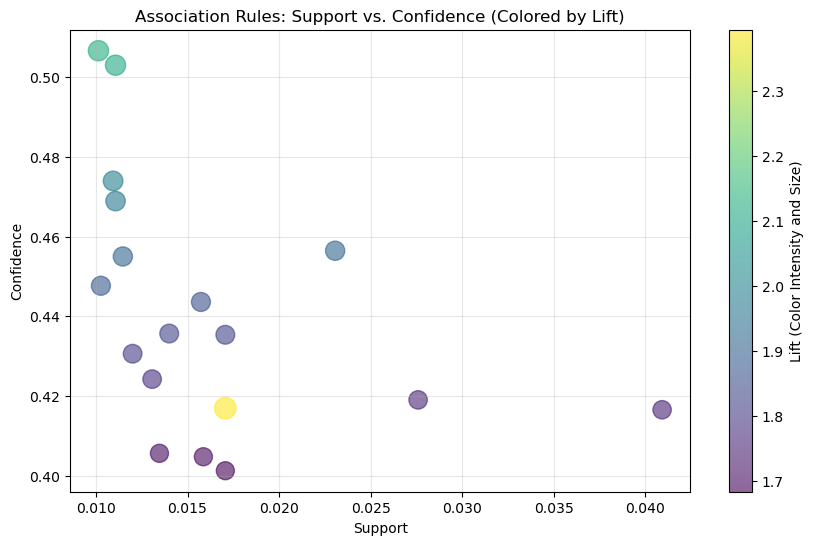

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(rules_viz['support'], rules_viz['confidence'], 
            c=rules_viz['lift'], cmap='viridis', 
            s=rules_viz['lift'] * 100, alpha=0.6)
plt.colorbar(label='Lift (Color Intensity and Size)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs. Confidence (Colored by Lift)')
plt.grid(True, alpha=0.3)
plt.show()


Visualization: A scatter plot showing the Support and Confidence of the top rules, with the 'Lift' value represented by color and size. Rules in brighter colors and larger sizes are the most interesting (highest Lift).

## 6. Interview Question :

**1. What is lift and why is it important in Association rules?**
   - **What it is:** Lift is a measure of how much more often the antecedent (A) and consequent (C) occur together than we would expect if they were statistically independent. It is calculated as:


 $$Lift(A \to C) = \frac{Confidence(A \to C)}{Support(C)} = \frac{P(A \cap C)}{P(A) \times P(C)}$$

 - **Why it is important:**
     - **Lift = 1:** Implies A and C are independent. The rule is not interesting.
     - **Lift > 1:** Implies A and C are positively correlated. The rule is useful for suggesting cross-selling. (e.g., customers who buy A are more likely to buy C).
     - **Lift < 1:** Implies A and C are negatively correlated. The presence of A decreases the likelihood of C.
   - Lift is crucial because it helps distinguish truly correlated items from items that are just frequently purchased due to high individual support (e.g., milk and bread are always bought, but a rule like {Bread} -> {Milk} may have high Confidence/Support but low Lift).


**Q2. What is Support and Confidence? How do you calculate them?**

 - **Support ($P(A \cap C)$):**

 - **Definition:** The fraction of all transactions that contain both the antecedent (A) and the consequent (C). It measures the **frequency** of the itemset $\{A, C\}$.

 - **Calculation:** $\text{Support}(A \to C) = \frac{\text{Number of transactions containing A and C}}{\text{Total number of transactions}}$

- **Confidence ($P(C | A)$):**

  - **Definition:** The probability that a transaction contains the consequent (C), *given* that the transaction already contains the antecedent (A). It measures the **reliability** of the rule.

  - **Calculation:** $\text{Confidence}(A \to C) = \frac{\text{Support}(A \to C)}{\text{Support}(A)} = \frac{\text{P}(A \cap C)}{\text{P}(A)}$

**Q3. What are some limitations or challenges of Association Rule Mining?**

 - **Scalability and Computational Cost (The "Trivial" Rule Problem):** In large datasets with millions of products, the number of potential itemsets ($2^N$ where $N$ is the number of items) is enormous. The Apriori algorithm and its derivatives can be computationally intensive.
   - **Generating Too Many Rules:** With low support thresholds, the algorithm can generate thousands of rules, many of which are obvious (e.g., {Coke} -> {Soda}) or completely uninteresting. This is known as the "rule explosion" problem.
   - **Sparsity:** Retail datasets are often very sparse (most customers buy only a tiny fraction of the available items), making it difficult to find itemsets with high enough support.
   - **Lack of Time Dimension:** Standard association rule mining does not account for the sequence or time of purchases, only the co-occurrence within a single basket.
   - **Subjectivity of Thresholds:** Choosing meaningful thresholds for support, confidence, and lift requires domain knowledge and significant experimentation; an inappropriate threshold can lead to missing key insights or being overwhelmed by noise.